In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.base import clone
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler




In [191]:
datos = pd.read_parquet("/Users/hamzatriki/preprocesadoFINAL2.parquet")
datos["distrito/ciudad"].value_counts()
datos["distrito/ciudad"]

1             Ciempozuelos
2                San Diego
3                vinateros
4                vinateros
5       Mejorada del Campo
               ...        
2622            Concepción
2624              Portazgo
2625              Aranjuez
2626         Puerta Bonita
2627              Aranjuez
Name: distrito/ciudad, Length: 1655, dtype: object

In [3]:
def create_model_backup(nombre_modelo,validation_error,cross_validation,stratify,RFE,grid,best_params = None,param_grid_dictionary= None,results=None,solver =None):
    """ recibe una serie de parametros y crea una diccionario con todos ello que posteriormente será usado
    para guardar toda la información del modelo en mlflow"""
    resultados = {}
    print(nombre_modelo)
    resultados["Modelo"] = nombre_modelo
    resultados["stratify"] = stratify 
    resultados["rfe"] = RFE 
    resultados["cv"] = cross_validation
    if solver:
        resultados["solver"] =solver
    if best_params is not None:
        resultados["mean_validation_error"] = validation_error
        resultados["best_params"] = best_params
        resultados_cv = []
    # Iterar sobre los resultados y agregarlos a la lista de resultados de Ridge
        for mean_score, params in zip(results['mean_test_score'], results['params']):
            dictionary = param_grid_dictionary.copy()
            for key, value in params.items():
                if not isinstance(value,str) and value <0:
                    print(value)
                    value= -value
                param_grid_dictionary[key] = value
            dictionary["validation_error"] = -mean_score
            resultados_cv.append(dictionary)
    # Agregar la lista de resultados de Ridge al diccionario de resultados
        resultados["cross_validation"] = resultados_cv
    else:
        resultados["train_error"] = validation_error
        
    return resultados; 

In [4]:
import mlflow
import mlflow.sklearn

def save_results_mlflow(diccionario_resultados, nombre_modelo, model):
    """ recibe un diccionario de los resultados creado por create_model_backup(),el nombre del modelo 
    y el modelo  y lo guarda en mlflow """
    ##mlflow.set_tracking_uri(None)
    mlflow.set_tracking_uri("sqlite:////Users/hamzatriki/BasesDeDatosMlfow2.db")
    mlflow.set_experiment("ProyectoTecnocasa")  # Nombre de tu experimento en MLflow
    with mlflow.start_run() as run:
        metric = 0.0 
        for key in diccionario_resultados.keys():
            try:
                if key == 'best_params':
                    for param_key, param_value in diccionario_resultados[key].items():
                        mlflow.log_param(f'best_{param_key}', param_value)
                elif key == 'cross_validation':
                    for dic in diccionario_resultados[key]:
                        log_metric_text = ""
                        for key,value in dic.items():
                            if key != "train_score":
                                log_metric_text+= f" {key}_ {value}"
                            else:
                                metric = value
                        mlflow.log_metric(log_metric_text, metric)
                elif "error" in key:
                    mlflow.log_metric(key, diccionario_resultados[key])
                else:
                    mlflow.log_param(key, diccionario_resultados[key])
            except KeyError as e:
                print(f"Error al procesar la clave {key}: {str(e)}")
        mlflow.sklearn.log_model(model, nombre_modelo)



In [5]:
def split_train_trest(X,y,stratify =None):
    """recibe los datos y un parametro de stratificación y devuelve el train y test. 
    se usa una semilla para obtener siempre los mismos datos."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = stratify, random_state=42)
    return X_train, X_test, y_train, y_test 

def one_hot_encoder(data):
    """recibe una lista de datos(X_train,X_test) y les realiza el one_hot_encodging"""
    encoded_data = []
    for dato in data:
        if isinstance(dato, pd.Series):
            dato = pd.DataFrame(dato)
        categorical_columns = dato.select_dtypes(include=["object"]).columns
        encoder = OneHotEncoder(sparse=False)
        encoded_columns = encoder.fit_transform(dato[categorical_columns])
        new_columns = encoder.get_feature_names_out(categorical_columns)
        data_encoded = pd.DataFrame(encoded_columns, columns=new_columns)
        dato.reset_index(drop=True, inplace=True)
        data_encoded.reset_index(drop=True, inplace=True)
        dato_encoded = pd.concat([dato.drop(categorical_columns, axis=1), data_encoded], axis=1)
        encoded_data.append(dato_encoded)

    return encoded_data[0], encoded_data[1]

def standardize(X_train,X_test):
    """recibe los datos y los estandariza"""
    scaler = StandardScaler()
    variables_estandarizar = ["Dormitorios","Superficie","Num_baños","Año_de_construccion","Latitud","Longitud"]
    X_train_encoded_scaled = X_train.copy()
    X_test_encoded_scaled = X_test.copy()
    X_train_encoded_scaled[variables_estandarizar] = scaler.fit_transform(X_train[variables_estandarizar])
    X_test_encoded_scaled[variables_estandarizar] = scaler.transform(X_test[variables_estandarizar])
    return X_train_encoded_scaled,X_test_encoded_scaled

def calculate_error(model,X,y):
    """ recibe un modelo y los datos y calcula el error del modelo"""
    test_predictions = model.predict(X)
    test_mse = mean_absolute_error(y, test_predictions)
    return test_mse

In [6]:
def linear_regresion_model(X,y):
    """ recibe los datos y devuelve el modelo y un diccionario con los resultados"""
    resultados = {}
    model = LinearRegression()
    model.fit(X,y)
    validation_error = calculate_error(model,X,y)
    resultados = create_model_backup(nombre_modelo="linear_regression",validation_error=validation_error,cross_validation=False,stratify=True,RFE=False,grid =False)
    return model,resultados

In [7]:


def regularization_model_cross_validation(X_train_encoded, y_train,param_grid,model,random):
    """ recibe los datos,el param_grid,el modelo y random (un boleano para saber si 
    usar grid_search o ramdom_search).Esta función sirve para todos los modelos 
    deregularización(Ridge,Lasso,ElasticNet). Devuelve un diccionario y el mejor modelo."""
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    if random:
        grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100,scoring='neg_mean_absolute_error', cv=kfold, random_state=42)
    else:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error')
    
    
    grid_search.fit(X_train_encoded, y_train)
    param_grid_dictionary =  {key: "" for key in param_grid.keys()}
        
    resultados = create_model_backup(nombre_modelo=f"{type(modelo).__name__}_regression_model_grid_cv_rfe",validation_error=-grid_search.best_score_,cross_validation=True,stratify=True,RFE=False,grid=True,best_params=grid_search.best_params_,param_grid_dictionary=param_grid_dictionary,results=grid_search.cv_results_)
    
    return grid_search.best_estimator_,resultados


In [8]:
def get_related_features(X):
    """Recibe los datos y devuelve los columnas que son relacionadas, son columnas que antes eran una pero al
    aplicar el one-hot-enconing ya no"""
    related_group = []
    related_groups_name = ["Tipo_de_inmueble", "Etiqueta","Tipo_"]
    for name in related_groups_name:
        columnas_filtradas = X.filter(regex=name)
        selected_column_names = columnas_filtradas.columns
        related_features_index = [X.columns.get_loc(col_name) for col_name in selected_column_names]
        related_group.append(related_features_index)
    return related_group
def get_protected_features(X):
    """devuelve las columnas protegidas,que son la de los distritos"""
    columnas_filtradas = X.filter(regex='distrito|ciudad_')
    selected_column_names = columnas_filtradas.columns
    protected_features_index = [X.columns.get_loc(col_name) for col_name in selected_column_names]
    return protected_features_index
    
class CustomRFE(RFE):
    """Modificación de la clase RFE para que no elimine nunca las variables de localización.Si elimina
    una variable del grupo de related_features, elimnara el resto"""
    def __init__(self, estimator, n_features_to_select=None, step=1, groups=None, protected_features=None):
        super().__init__(estimator, n_features_to_select=n_features_to_select, step=step)
        self.groups = groups
        self.protected_features = protected_features

    def fit(self, X, y):
        self.support_ = np.ones(X.shape[1], dtype=bool)
        estimator = clone(self.estimator)
        super().fit(X, y)
        if self.groups or self.protected_features:
            for idx, selected in enumerate(self.support_):
                if not selected:
                    for related_features in self.groups:
                        if idx in related_features:
                            for feature_idx in related_features:
                                self.support_[feature_idx] = False
                    if idx in self.protected_features:
                        self.support_[idx] = True 
        return self  


def polinomical_regression_model_rfe(X, y,custom):
    """recibe los datos y un parametro custom, dependiendo de su valor, realiza el rfe customizado o no.
    Entrenama un modelo polinomico con grid_search y devuelve las columnas seleccionadas, el diccionario de 
    resultados y las columnas seleccionadas.
    """
    
    related_group = None
    protected_features_index = None
    
    if custom:
        related_group = get_related_features(X); 
        protected_features_index = get_protected_features(X)
        
    
    rfe = CustomRFE(estimator=Ridge(random_state =42), groups=related_group, protected_features=protected_features_index)

    # Aplica el CustomRFE a tus datos
    rfe.fit(X, y)

    # Obtén las características seleccionadas
    selected_features = rfe.support_
    columnas_seleccionadas = X.columns[selected_features]
    X_RFE = X[columnas_seleccionadas]
    
    
 
    param_grid = {
    'alpha': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,14,15,16,17,18,20,22,24,26,28,30,35,40,45,50], 
    'tol': [1e-2,1e-3, 1e-4,]             
    }
    
    param_grid_dictionary =  {key: "" for key in param_grid.keys()}

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(estimator=Ridge(random_state =42), param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error')
    
    grid_search.fit(X_RFE, y)
    
    resultados = create_model_backup(nombre_modelo="linear_regression_model_grid_cv_rfe",validation_error=-grid_search.best_score_,cross_validation=True,stratify=True,RFE=True,grid=True,best_params=grid_search.best_params_,param_grid_dictionary=param_grid_dictionary,results=grid_search.cv_results_)

    return grid_search.best_estimator_, resultados, columnas_seleccionadas

In [9]:
def concat_input_output(residuos,X_test,y_test,X_train,y_train):
    residuos.name = "residuos"
    residuosTrain.name = "residuos"
    datosTestConResiduos = pd.concat([X_test,y_test.reset_index(drop =True),residuos.reset_index(drop = True)],axis =1)
    datosTrainConResiduos = pd.concat([X_train,y_train.reset_index(drop =True),residuosTrain.reset_index(drop = True)],axis=1)
    return datosTestConResiduos,datosTrainConResiduos

In [10]:
def obtener_distritos_con_gran_error(y_test,residuos,X_test):
    y_test_reset = y_test.reset_index(drop=True)
    residuos_reset = residuos.reset_index(drop=True)
    mediana_por_distrito = pd.DataFrame({'Residuos': residuos_reset, 'Distrito/Ciudad': X_test['distrito/ciudad']}).groupby('Distrito/Ciudad').median()
    distritos_con_residuos_altos = mediana_por_distrito[mediana_por_distrito['Residuos'] > 80000]
    distritos_con_residuos_bajos = mediana_por_distrito[mediana_por_distrito['Residuos'] < 14000]

    return distritos_con_residuos_altos,distritos_con_residuos_bajos

## Transformaciones a las variables
- Dividimos los datos en train/test
- Aplicamos el one hot encoding a las variables categóticas
- Escalamos nuestros datos

In [11]:
X = datos.drop(columns = "Precio")
y = datos["Precio"]
stratify = datos["distrito/ciudad"]
X_train, X_test, y_train, y_test = split_train_trest(X,y,stratify)
X_train_encoded, X_test_encoded= one_hot_encoder([X_train, X_test])
X_train_encoded_scaled,X_test_encoded_scaled = standardize(X_train_encoded, X_test_encoded)

## Modelo de regresion lineal
- Primera aproximacion

In [12]:
modelo_regresion_lineal,results = linear_regresion_model(X_train_encoded_scaled,y_train)
results["test_error"] = calculate_error(modelo_regresion_lineal,X_test_encoded_scaled,y_test)
save_results_mlflow(results,"modelo de regresion lineal",modelo_regresion_lineal)
results

linear_regression


/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


{'Modelo': 'linear_regression',
 'stratify': True,
 'rfe': False,
 'cv': False,
 'train_error': 51255.51986183074,
 'test_error': 56944.76458752515}

## Gráfico de dispersión de los reiduos

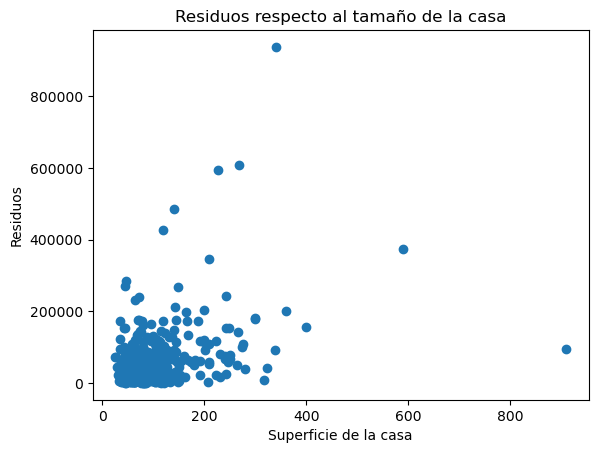

In [13]:
predicciones = modelo_regresion_lineal.predict(X_test_encoded_scaled)
residuos = abs(predicciones-y_test)
plt.scatter(X_test_encoded["Superficie"],residuos)
plt.title("Residuos respecto al tamaño de la casa")
plt.xlabel("Superficie de la casa")
plt.ylabel("Residuos")
plt.show()

Observamos un patrón notable: a mayor superficie de la casa, mayor es el residuo, lo que sugiere que la varianza de los residuos es heterocedasticidad. Esto afecta demasiado a nuestro modelo, ya que como sabemos, el modelo de regresión lineal es muy sensible a valores atípicos (en este caso, casas de gran tamaño). Intenta adaptarse a ellos, pero no solo no lo consigue, sino que en el intento empeora al resto, que representa la gran mayoría.

In [14]:
superficies = X["Superficie"]
superficies_ordenadas = np.sort(superficies)

indice_percentil = int(0.977 * len(superficies_ordenadas))

# Encuentra el valor de la superficie en el índice calculado
superficie_percentil = superficies_ordenadas[indice_percentil]
superficie_percentil

300.0

Observamos que las propiedades mayores de 300m2 solo representan el 2.3% de nuestros datos, por lo que decidimos quitarlos para ver cómo se comporta el modelo

In [15]:
filtro = datos["Superficie"] < 300
datos = datos[filtro]


In [16]:
X = datos.drop(columns = "Precio")
y = datos["Precio"]
stratify = datos["distrito/ciudad"]
X_train, X_test, y_train, y_test = split_train_trest(X,y,stratify)
X_train_encoded, X_test_encoded= one_hot_encoder([X_train, X_test])
X_train_encoded_scaled,X_test_encoded_scaled = standardize(X_train_encoded, X_test_encoded)
modelo_regresion_lineal_mejorado,results = linear_regresion_model(X_train_encoded_scaled,y_train)
results["test_error"] = calculate_error(modelo_regresion_lineal_mejorado,X_test_encoded_scaled,y_test)
save_results_mlflow(results,"modelo de regresion lineal mejorado",modelo_regresion_lineal_mejorado)
results

linear_regression


{'Modelo': 'linear_regression',
 'stratify': True,
 'rfe': False,
 'cv': False,
 'train_error': 42371.00795755968,
 'test_error': 47632.81855670103}

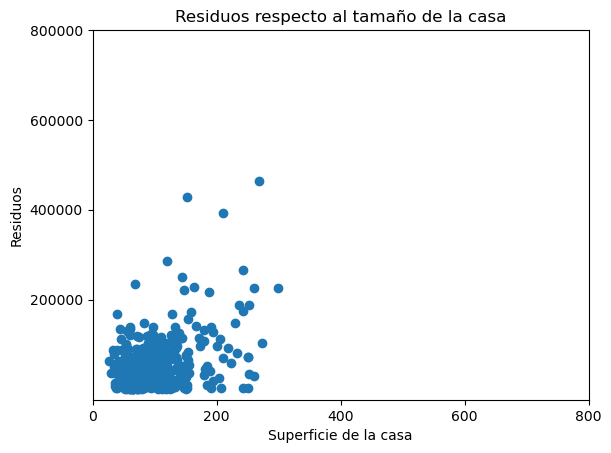

In [17]:
predicciones = modelo_regresion_lineal_mejorado.predict(X_test_encoded_scaled)
residuos = abs(predicciones-y_test)
plt.scatter(X_test_encoded["Superficie"],residuos)
plt.title("Residuos respecto al tamaño de la casa")
plt.xlabel("Superficie de la casa")
plt.ylabel("Residuos")
plt.xticks([0,200,400,600,800])
plt.yticks([200000,400000,600000,800000])
plt.show()

Este pequeño cambio hace que nuestro modelo mejore considerablemente, pasando de un test_error de 56944 a 47632

In [18]:
modelo_regresion_lineal_mejorado.coef_

array([ 2.86229221e+03,  8.61163540e+04,  1.93958143e+04,  6.04509647e+03,
        1.42604189e+04,  1.20113618e+04,  7.11765028e+03,  1.10541341e+04,
        9.53043018e+03, -7.14636597e+03,  8.04618988e+14,  1.06347492e+15,
       -3.72499899e+15, -3.72499899e+15, -3.72499899e+15, -3.72499899e+15,
        2.42481675e+16,  2.42481675e+16,  2.42481675e+16,  2.42481675e+16,
        2.42481675e+16,  2.42481675e+16,  2.42481675e+16,  2.42481675e+16,
       -2.84708308e+16, -2.84708308e+16, -2.84708308e+16, -2.40619051e+15,
       -4.23171231e+15, -2.69533748e+15,  1.95986740e+14, -1.02237162e+15,
       -6.60752450e+14,  1.01308929e+15, -2.28708333e+15,  1.46632527e+15,
       -2.58791098e+15, -1.49443614e+15, -1.57452937e+15,  1.12799561e+14,
        1.00541498e+15, -4.64989381e+15, -2.03393674e+15, -2.12604800e+15,
       -6.10983183e+14, -9.17054974e+14, -1.53617365e+15, -1.64678642e+15,
       -1.80944244e+15,  1.58058055e+14, -1.87712365e+15, -8.79429555e+14,
       -2.66402177e+15, -

Observamos los pesos que toman las variables y nos encontramos con que todas las variables de las localizaciones tienen un coeficiente muy grande y exactamente el mismo peso. Buscando un poco de información, este fenómeno es conocido como "maldición de la dimensionalidad" o "curse of dimensionality". En nuestro caso, esto sucede debido a la transformación de las variables de localización en variables dicotómicas. Esta transformación aumenta la complejidad de nuestros datos y nuestro modelo no captura la relación que existe entre la localización de la casa y el precio. Para solucionar este problema, vamos a probar a utilizar modelos de regularización, eliminar variables y análisis de componentes principales.

## Conclusión del primer modelo
- El modelo es propenso a adaptarse a datos atipicos empeorando el resto de la predicciónes.
- La difrencia entre el train y el test error es de mas de 10000, lo que suguiere que está sobreajustando en el entrenamiento.
- No captura las relaciones entre las casas y los distritos.
- Eliminar los datos de las casas mayores de 300m2 permite que nuestro modelo se comporte mejor con la gran mayoría de los datos (97.7%), a coste de predecir peor las casas grandes (La mediana del residuos de las casas mayores de 300m2 es de más de 220000 ,más de 4 veces nuestro test error por lo que ya predecía muy mal estas casas).

## Modelos de regularizacións
- Ridge
    - GridSeach
    - RandomSearch
- Lasso
    - GridSeach
    - RandomSearch
- ElasticNet
    - GridSeach
    - RandomSearch

_Ridge con grid_search()_

In [19]:
alphas = np.logspace(start=-3, stop=3, num=7)
alphas = np.append(alphas,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,14,15,16,17,18,20,22,24,26,28,30,35,40,45,50])
param_grid = {
    'alpha': alphas,
    'tol': [1e-2,1e-3, 1e-4,]          
}
modelo = Ridge(random_state=42)
modelo_ridge,resultados = regularization_model_cross_validation(X_train_encoded_scaled,y_train,param_grid,modelo,random=False)
resultados["train_error"] = calculate_error(modelo_ridge,X_train_encoded_scaled,y_train)
resultados["test_error"] = calculate_error(modelo_ridge,X_test_encoded_scaled,y_test)
save_results_mlflow(resultados,"modelo de regresion ridge con gridSeach",modelo_ridge)
resultados

Ridge_regression_model_grid_cv_rfe


{'Modelo': 'Ridge_regression_model_grid_cv_rfe',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 49595.38761058323,
 'best_params': {'alpha': 1.0, 'tol': 0.01},
 'cross_validation': [{'alpha': '',
   'tol': '',
   'validation_error': 50153.653648722786},
  {'alpha': 0.001, 'tol': 0.01, 'validation_error': 50153.653648722786},
  {'alpha': 0.001, 'tol': 0.001, 'validation_error': 50153.653648722786},
  {'alpha': 0.001, 'tol': 0.0001, 'validation_error': 50137.40153650474},
  {'alpha': 0.01, 'tol': 0.01, 'validation_error': 50137.40153650474},
  {'alpha': 0.01, 'tol': 0.001, 'validation_error': 50137.40153650474},
  {'alpha': 0.01, 'tol': 0.0001, 'validation_error': 49986.91615883486},
  {'alpha': 0.1, 'tol': 0.01, 'validation_error': 49986.91615883486},
  {'alpha': 0.1, 'tol': 0.001, 'validation_error': 49986.91615883486},
  {'alpha': 0.1, 'tol': 0.0001, 'validation_error': 49595.38761058323},
  {'alpha': 1.0, 'tol': 0.01, 'validation_error': 49595.38761058323},


In [20]:
modelo_ridge.coef_

array([ 8.50233781e+02,  8.76556592e+04,  2.21459900e+04,  3.11893394e+04,
        1.40076694e+04,  4.18596303e+03,  6.88734695e+03,  9.96826599e+03,
        1.18493598e+04, -1.10209762e+04,  2.52297775e+04, -1.42851972e+04,
        3.86589351e+03, -1.44664488e+04, -9.33242861e+03,  1.99329839e+04,
       -4.41988692e+04,  4.44490688e+04, -1.35545458e+03,  1.53573631e+04,
       -4.91087693e+02, -2.24498426e+03, -4.17174656e+02, -1.10988616e+04,
        4.28759817e+04, -3.74433541e+04, -5.43262765e+03,  8.57940716e+04,
       -3.15185189e+04, -6.68181094e+03, -4.43256394e+04, -7.17983679e+03,
       -1.63277684e+04, -6.68524604e+03, -2.32486375e+04, -1.04201609e+05,
        8.35643175e+04, -1.71265290e+03,  5.07058384e+04,  1.24802167e+05,
       -7.48226412e+04, -8.01817018e+04,  2.39959728e+04, -1.99777176e+04,
       -4.37945919e+04,  1.93045730e+05, -4.20766849e+04,  7.78164141e+04,
        9.42316823e+04, -2.55872828e+04, -2.58993822e+04, -1.32537863e+05,
       -6.92506994e+04,  

Ejecutamos el modelo Ridge con grid search ajustando estos hiperparámetros: {'alpha': 'tol':}. El mejor modelo tiene como parámetro de regularización alpha = 1. Cuando alpha es igual a 1, el término de regularización penaliza significativamente los coeficientes del modelo, lo que puede reducir la magnitud de los coeficientes y ayudar a prevenir el sobreajuste del modelo. Podemos observar que los coeficientes de las localizaciones ya son distintos y mucho más pequeños, lo que indica que nuestro modelo está comenzando a capturar las relaciones existentes entre los distritos y las propiedades. El test_error ha bajado un poco más hasta 47191.

Ridge con random_search()

In [21]:
param_grid = {
            'alpha': uniform(0.1, 100), 
            'tol': [1e-2,1e-3, 1e-4]      # Método de solución
        }
modelo = Ridge(random_state=42)
modelo_ridge_random_search,resultados = regularization_model_cross_validation(X_train_encoded_scaled,y_train,param_grid,modelo,random=True)
resultados["train_error"] = calculate_error(modelo_ridge_random_search,X_train_encoded_scaled,y_train)
resultados["test_error"] = calculate_error(modelo_ridge_random_search,X_test_encoded_scaled,y_test)
save_results_mlflow(resultados,"modelo de regresion ridge con randomSearch",modelo_ridge_random_search)
resultados

Ridge_regression_model_grid_cv_rfe


{'Modelo': 'Ridge_regression_model_grid_cv_rfe',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 50063.65848151733,
 'best_params': {'alpha': 2.1584494295802448, 'tol': 0.001},
 'cross_validation': [{'alpha': '',
   'tol': '',
   'validation_error': 58944.45367289843},
  {'alpha': 37.55401188473625,
   'tol': 0.01,
   'validation_error': 56648.52675916614},
  {'alpha': 18.44347898661638,
   'tol': 0.01,
   'validation_error': 60151.04871714157},
  {'alpha': 59.7850157946487,
   'tol': 0.001,
   'validation_error': 56060.02708341418},
  {'alpha': 15.699452033620265,
   'tol': 0.0001,
   'validation_error': 59486.77015897322},
  {'alpha': 46.02488919658672,
   'tol': 0.01,
   'validation_error': 60168.13806326881},
  {'alpha': 60.21150117432088,
   'tol': 0.0001,
   'validation_error': 50063.65848151733},
  {'alpha': 2.1584494295802448,
   'tol': 0.001,
   'validation_error': 60606.376518745165},
  {'alpha': 72.29987722668247,
   'tol': 0.001,
   'validation_erro

Observamos que el test error y los hiperparametros tienen valores similares usando grid_search y random_search, elegimos el de menor test_error y lo modelamos

In [19]:
mejor_modelo_ridge = Ridge(random_state=42,alpha =1, tol = 0.01)
mejor_modelo_ridge.fit(X_train_encoded_scaled,y_train)
train_error = calculate_error(mejor_modelo_ridge,X_train_encoded_scaled,y_train)
resultados = create_model_backup(nombre_modelo="best_model_ridge",validation_error=train_error,cross_validation=False,stratify=True,RFE=False,grid=False)
resultados["test_error"] =  calculate_error(mejor_modelo_ridge,X_test_encoded_scaled,y_test)
resultados

best_model_ridge


{'Modelo': 'best_model_ridge',
 'stratify': True,
 'rfe': False,
 'cv': False,
 'train_error': 42743.02943217039,
 'test_error': 47191.09989616069}

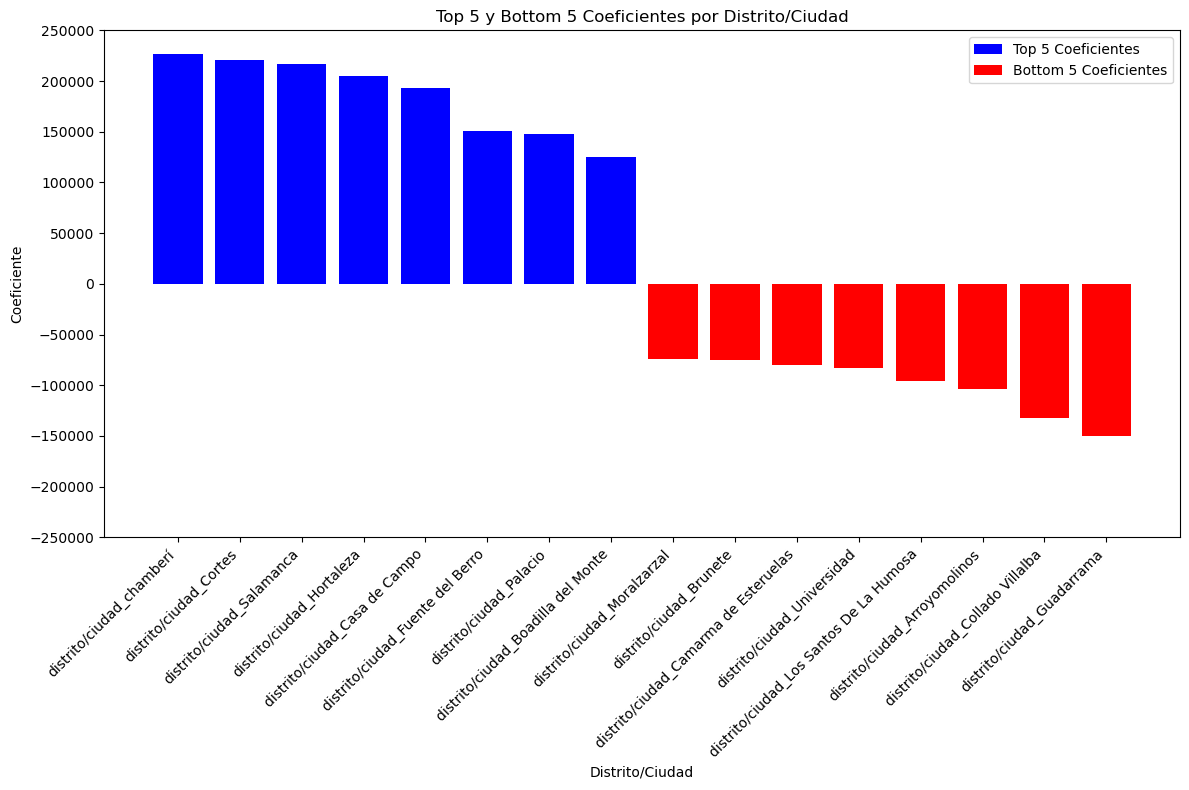

In [35]:
coeficientes = pd.DataFrame(mejor_modelo_ridge.coef_, columns=["Coeficiente"], index=X_train_encoded.columns)

coeficientes_ordenados = coeficientes.sort_values(by="Coeficiente", ascending=False)

mejores_coeficientes = coeficientes_ordenados.head(8)

peores_coeficientes = coeficientes_ordenados.tail(8)
plt.figure(figsize=(12, 8))

plt.bar(mejores_coeficientes.index, mejores_coeficientes["Coeficiente"], color="blue", label="Top 5 Coeficientes")

plt.bar(peores_coeficientes.index, peores_coeficientes["Coeficiente"], color="red", label="Bottom 5 Coeficientes")

plt.xlabel("Distrito/Ciudad")
plt.ylabel("Coeficiente")
plt.title("Top 5 y Bottom 5 Coeficientes por Distrito/Ciudad")
plt.yticks([-250000,-200000,-150000,-100000,-50000,0,50000,100000,150000,200000,250000])
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.legend()
plt.tight_layout()
plt.show()


_Seguimos con el Lasso y el Elastic-net_

In [25]:
alphas = np.append(alphas,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,14,15,16,17,18,20,22,24,26,28,30,35,40,45,50,105,110,115,120,125,130,150,175,200])
param_grid = {
    'alpha': alphas,
    'tol': [1e-2,1e-3, 1e-4,]          
}
modelo = Lasso(random_state =42)
modelo_lasso_grid_search,resultados = regularization_model_cross_validation(X_train_encoded_scaled,y_train,param_grid,modelo,random = False)
resultados["train_error"] = calculate_error(modelo_lasso_grid_search,X_train_encoded_scaled,y_train)
resultados["test_error"] = calculate_error(modelo_lasso_grid_search,X_test_encoded_scaled,y_test)
save_results_mlflow(resultados,"modelo de regresion Lasso con gridSeach",modelo_lasso_grid_search)
resultados

/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+12, tolerance: 2.055e+11
  model = cd_fast.enet_coordinate_descent(
/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+12, tolerance: 1.832e+11
  model = cd_fast.enet_coordinate_descent(
/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Lasso_regression_model_grid_cv_rfe


{'Modelo': 'Lasso_regression_model_grid_cv_rfe',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 49591.61631961601,
 'best_params': {'alpha': 100.0, 'tol': 0.01},
 'cross_validation': [{'alpha': '',
   'tol': '',
   'validation_error': 50155.468063634304},
  {'alpha': 0.001, 'tol': 0.01, 'validation_error': 50155.468063634304},
  {'alpha': 0.001, 'tol': 0.001, 'validation_error': 50155.468063634304},
  {'alpha': 0.001, 'tol': 0.0001, 'validation_error': 50155.285485487504},
  {'alpha': 0.01, 'tol': 0.01, 'validation_error': 50155.285485487504},
  {'alpha': 0.01, 'tol': 0.001, 'validation_error': 50155.285485487504},
  {'alpha': 0.01, 'tol': 0.0001, 'validation_error': 50153.522365153935},
  {'alpha': 0.1, 'tol': 0.01, 'validation_error': 50153.522365153935},
  {'alpha': 0.1, 'tol': 0.001, 'validation_error': 50153.522365153935},
  {'alpha': 0.1, 'tol': 0.0001, 'validation_error': 50138.88272171712},
  {'alpha': 1.0, 'tol': 0.01, 'validation_error': 50138.890015

In [26]:
modelo_lasso_grid_search.coef_

array([ 8.90800303e+02,  8.75788521e+04,  2.16376285e+04,  3.00368113e+04,
        8.26968592e+03,  4.39686232e+03,  7.12935040e+03,  1.06229817e+04,
        1.20766112e+04, -1.06658784e+04,  2.63921517e+04, -2.19192601e+04,
        0.00000000e+00, -9.65128012e+03, -4.87786895e+03,  2.34411035e+04,
       -3.21322137e+04,  3.80551377e+04, -0.00000000e+00,  1.38602807e+04,
        3.94269495e+01, -0.00000000e+00, -0.00000000e+00, -6.11517965e+03,
        4.59444584e+04, -3.09554143e+04, -0.00000000e+00,  1.03438074e+05,
        0.00000000e+00,  0.00000000e+00, -2.69652345e+04,  0.00000000e+00,
       -0.00000000e+00,  6.94032439e+03,  0.00000000e+00, -9.76846450e+04,
        9.77219430e+04,  0.00000000e+00,  5.65714698e+04,  1.37906547e+05,
       -6.84805013e+04, -4.33059249e+04,  3.05620806e+04, -0.00000000e+00,
       -2.84344256e+04,  2.16259002e+05, -1.10646012e+04,  8.81482354e+04,
        1.06585406e+05, -0.00000000e+00, -0.00000000e+00, -1.33264213e+05,
       -5.67045237e+04,  

Observamos que el lasso ha pesto algunos coeficientes a cero

In [27]:
param_grid = {
            'alpha': uniform(0.1, 100), 
            'tol': [1e-2,1e-3, 1e-4]      # Método de solución
        }
modelo = Lasso(random_state=42)
modelo_lasso_random_search,resultados = regularization_model_cross_validation(X_train_encoded_scaled,y_train,param_grid,modelo,random=True)
resultados["train_error"] = calculate_error(modelo_lasso_random_search,X_train_encoded_scaled,y_train)
resultados["test_error"] = calculate_error(modelo_lasso_random_search,X_test_encoded_scaled,y_test)
save_results_mlflow(resultados,"modelo de regresion Lasso con randomSearch",modelo_lasso_random_search)
resultados

/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+12, tolerance: 2.055e+10
  model = cd_fast.enet_coordinate_descent(
/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e+10, tolerance: 1.832e+10
  model = cd_fast.enet_coordinate_descent(
/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Lasso_regression_model_grid_cv_rfe


{'Modelo': 'Lasso_regression_model_grid_cv_rfe',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 49551.69772716415,
 'best_params': {'alpha': 77.22703466859457, 'tol': 0.01},
 'cross_validation': [{'alpha': '',
   'tol': '',
   'validation_error': 49681.838545401595},
  {'alpha': 37.55401188473625,
   'tol': 0.01,
   'validation_error': 49871.778435051776},
  {'alpha': 18.44347898661638,
   'tol': 0.01,
   'validation_error': 49574.43452973671},
  {'alpha': 59.7850157946487,
   'tol': 0.001,
   'validation_error': 49902.95115931216},
  {'alpha': 15.699452033620265,
   'tol': 0.0001,
   'validation_error': 49630.97790762122},
  {'alpha': 46.02488919658672,
   'tol': 0.01,
   'validation_error': 49573.829007001164},
  {'alpha': 60.21150117432088,
   'tol': 0.0001,
   'validation_error': 50119.16815991404},
  {'alpha': 2.1584494295802448,
   'tol': 0.001,
   'validation_error': 49555.622827915045},
  {'alpha': 72.29987722668247,
   'tol': 0.001,
   'validation_err

Obtenemos resultados ligeramente superiores llegando a 46718

In [28]:
param_grid = {
    'alpha': [0.1,0.3,0.5,0.7,0.9],  # Valores para el parámetro de regularización
    'fit_intercept': [True, False],           # Si se debe ajustar el término de intercepción
    'tol': [1e-2,1e-3, 1e-4,]             # Tolerancia para la convergencia
}
modelo = ElasticNet()
modelo_elasticNet_grid_search,resultados = regularization_model_cross_validation(X_train_encoded_scaled,y_train,param_grid,modelo,random =False)
resultados["train_error"] = calculate_error(modelo_elasticNet_grid_search,X_train_encoded_scaled,y_train)
resultados["test_error"] = calculate_error(modelo_elasticNet_grid_search,X_test_encoded_scaled,y_test)
save_results_mlflow(resultados,"modelo de regresion ElisticNet",modelo_elasticNet_grid_search)
resultados

ElasticNet_regression_model_grid_cv_rfe


{'Modelo': 'ElasticNet_regression_model_grid_cv_rfe',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 59443.11632700129,
 'best_params': {'alpha': 0.1, 'fit_intercept': True, 'tol': 0.0001},
 'cross_validation': [{'alpha': '',
   'fit_intercept': '',
   'tol': '',
   'validation_error': 59443.116614282815},
  {'alpha': 0.1,
   'fit_intercept': True,
   'tol': 0.01,
   'validation_error': 59443.1163762641},
  {'alpha': 0.1,
   'fit_intercept': True,
   'tol': 0.001,
   'validation_error': 59443.11632700129},
  {'alpha': 0.1,
   'fit_intercept': True,
   'tol': 0.0001,
   'validation_error': 61582.01531852933},
  {'alpha': 0.1,
   'fit_intercept': False,
   'tol': 0.01,
   'validation_error': 61582.0028038567},
  {'alpha': 0.1,
   'fit_intercept': False,
   'tol': 0.001,
   'validation_error': 61582.000525648335},
  {'alpha': 0.1,
   'fit_intercept': False,
   'tol': 0.0001,
   'validation_error': 62042.390142718315},
  {'alpha': 0.3,
   'fit_intercept': True,
  

In [93]:
# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    "alpha": uniform(0.1, 1),  # Valores para el parámetro de regularización
    'tol': [1e-2, 1e-3, 1e-4]             # Tolerancia para la convergencia
}

# Crear el objeto del modelo
modelo = ElasticNet()

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

# Realizar la búsqueda de hiperparámetros
random_search.fit(X_train_encoded_scaled, y_train)

# Obtener el mejor modelo
mejor_modelo_elasticNet = random_search.best_estimator_

# Calcular los errores en el conjunto de entrenamiento y prueba
train_error = calculate_error(mejor_modelo_elasticNet, X_train_encoded_scaled, y_train)
test_error = calculate_error(mejor_modelo_elasticNet, X_test_encoded_scaled, y_test)

# Guardar los resultados
resultados = {
    "train_error": train_error,
    "test_error": test_error
}

# Guardar el modelo en MLflow
save_results_mlflow(resultados, "modelo de regresion ElasticNet", mejor_modelo_elasticNet)

In [98]:
random_search.best_estimator_

ElasticNet(alpha=0.12058449429580245, tol=0.001)

In [92]:
random_search.best_score_,resultados

(0.6056416801655524,
 {'train_error': 57505.4852119287, 'test_error': 59008.63049437167})

## Conclusiones
- Los modelos de regularización mejoran mucho nuestro modelo ya que penalizan los coeficiente grandes
- El test error más bajo obtenido es de 46718 que pertenece al modelo Lasso.
- Hemos decidio quedarnos con el modelo Ridge() para continuar con las pruebas aunque no sea el de menos error. El Lasso pone coeficientes a cero y preferimos tener todas las variables aunque tenga un coeficiente muy bajo.

## Analisis de componentes principales

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

param_grid = {
    'n_components': [ 2, 3, 4,5],  # Lista de valores posibles para el número de componentes
}


grid_search_LDA = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5)

grid_search_LDA.fit(X_train_encoded_scaled, y_train)

param_grid_dictionary =  {key: "" for key in param_grid.keys()}


resultados = create_model_backup(nombre_modelo="Analisis de Componenetes Principales",validation_error=grid_search_LDA.best_score_,cross_validation=True,stratify=True,RFE=False,grid=True,best_params=grid_search_LDA.best_params_,param_grid_dictionary=param_grid_dictionary,results=grid_search_LDA.cv_results_)
resultados["train_error"] = calculate_error(grid_search_LDA,X_train_encoded_scaled,y_train)
resultados["test_error"] = calculate_error(grid_search_LDA,X_test_encoded_scaled,y_test)
save_results_mlflow(resultados,"modelo de regresion ElisticNet",grid_search_LDA)
resultados

/Users/hamzatriki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Analisis de Componenetes Principales


{'Modelo': 'Analisis de Componenetes Principales',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 0.013266539316205994,
 'best_params': {'n_components': 2},
 'cross_validation': [{'n_components': '',
   'validation_error': -0.013266539316205994},
  {'n_components': 2, 'validation_error': -0.013266539316205994},
  {'n_components': 3, 'validation_error': -0.013266539316205994},
  {'n_components': 4, 'validation_error': -0.013266539316205994}],
 'train_error': 62159.62157382847,
 'test_error': 86671.61237113402}

EL modelo sobreajusto mucho y el test_error es muy malo

## Modelo polinomico con regularización Ridge
- Calculamos primera aproximación con hiperparamtros a mano
- GridSearch
- RandomSearch

Calculamos un primer modelo polinomico con regularización Ridge()

In [36]:
pipeline_polinomico_ridge = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)), 
    ("ridge_reg", Ridge(alpha=3.5))  
])

pipeline_polinomico_ridge.fit(X_train_encoded_scaled, y_train)


calculate_error(pipeline_polinomico_ridge,X_test_encoded_scaled,y_test)

42411.707700285515

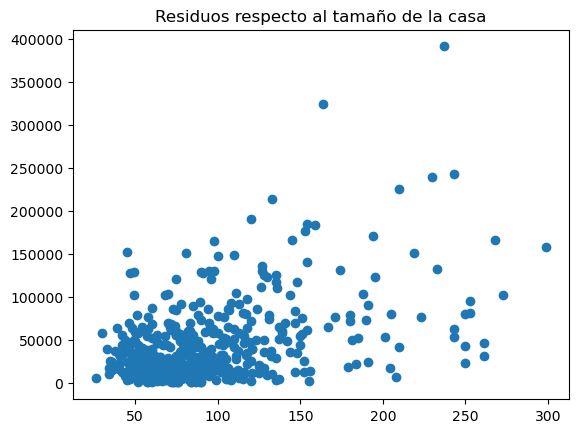

In [37]:
predicciones = pipeline_polinomico_ridge.predict(X_test_encoded_scaled)
residuos = abs(predicciones-y_test)
residuosTrain = abs(pipeline_polinomico_ridge.predict(X_train_encoded_scaled)-y_train)
plt.scatter(X_test_encoded["Superficie"],residuos)
plt.title("Residuos respecto al tamaño de la casa")
plt.show()

Modelo Polinomico con Regularicación y RamdomSeach

In [35]:
from scipy.stats import uniform, randint

param_grid = {
    "poly_features__degree": randint(1, 3), 
    "ridge_reg__alpha": uniform(0.1, 1000)  
}
param_grid_dictionary =  {key: "" for key in param_grid.keys()}

pipeline_polinomico_ridge = Pipeline([
    ("poly_features", PolynomialFeatures()), 
    ("ridge_reg", Ridge()) 
])



pipeline_polinomico_ridge_random_search = RandomizedSearchCV(
    estimator=pipeline_polinomico_ridge,  
    param_distributions=param_grid,  
    n_iter=100, 
    scoring="neg_mean_absolute_error",  
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42  
)

pipeline_polinomico_ridge_random_search.fit(X_train_encoded_scaled, y_train)



modelo_polinomico_ridge_random = pipeline_polinomico_ridge_random_search.best_estimator_
resultados = create_model_backup(nombre_modelo="modelo polinomico con regularización ridge y randomSearch",validation_error=-pipeline_polinomico_ridge_random_search.best_score_,cross_validation=True,stratify=True,RFE=False,grid=True,best_params=pipeline_polinomico_ridge_random_search.best_params_,param_grid_dictionary=param_grid_dictionary,results=pipeline_polinomico_ridge_random_search.cv_results_)
resultados["train_error"] = calculate_error(modelo_polinomico_ridge_random, X_train_encoded_scaled, y_train)
resultados["test_error"] = calculate_error(modelo_polinomico_ridge_random, X_test_encoded_scaled, y_test)
save_results_mlflow(resultados,"modelo polinomico con regularización ridge y randomSearch",modelo_polinomico_ridge_random)

resultados



modelo polinomico con regularización ridge y randomSearch


{'Modelo': 'modelo polinomico con regularización ridge y randomSearch',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 43946.04248267707,
 'best_params': {'poly_features__degree': 2,
  'ridge_reg__alpha': 14.179822715084455},
 'cross_validation': [{'poly_features__degree': '',
   'ridge_reg__alpha': '',
   'validation_error': 70189.40055834048},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 796.6429868602329,
   'validation_error': 69557.51346748637},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 732.0939418114051,
   'validation_error': 68115.66688659362},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 596.950157946487,
   'validation_error': 49841.55149746248},
  {'poly_features__degree': 2,
   'ridge_reg__alpha': 156.09452033620263,
   'validation_error': 66497.93980388732},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 459.34889196586715,
   'validation_error': 68164.04980102775},
  {'poly_features__degree': 1,
   'ridge_reg_

Modelo Polinomico con Regularicación y GridSearch

In [36]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

param_grid = {
    "poly_features__degree": [1, 2, 3],  
    "ridge_reg__alpha": [0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,300,400,500,600,700,800,900,1000]  # Parámetro de regularización alpha entre 0.1 y 20.0
}
param_grid_dictionary =  {key: "" for key in param_grid.keys()}

pipeline_polinomico_ridge = Pipeline([
    ("poly_features", PolynomialFeatures()), 
    ("ridge_reg", Ridge()) 
])


pipeline_polinomico_ridge_grid_search = GridSearchCV(
    estimator=pipeline_polinomico_ridge,  
    param_grid=param_grid,  
    scoring="neg_mean_absolute_error", 
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

pipeline_polinomico_ridge_grid_search.fit(X_train_encoded_scaled, y_train)

modelo_polinomico_ridge_grid_search = pipeline_polinomico_ridge_grid_search.best_estimator_
resultados = create_model_backup(
    nombre_modelo="modelo polinomico con regularización ridge y GridSearch",
    validation_error=-pipeline_polinomico_ridge_grid_search.best_score_,
    cross_validation=True,
    stratify=True,
    RFE=False,
    grid=True,
    best_params=pipeline_polinomico_ridge_grid_search.best_params_,
    param_grid_dictionary=param_grid_dictionary,
    results=pipeline_polinomico_ridge_grid_search.cv_results_
)
resultados["train_error"] = calculate_error(modelo_polinomico_ridge_grid_search, X_train_encoded_scaled, y_train)
resultados["test_error"] = calculate_error(modelo_polinomico_ridge_grid_search, X_test_encoded_scaled, y_test)
save_results_mlflow(resultados,"modelo polinomico con regularización ridge y GridSearch",modelo_polinomico_ridge_grid_search)
resultados


modelo polinomico con regularización ridge y GridSearch


{'Modelo': 'modelo polinomico con regularización ridge y GridSearch',
 'stratify': True,
 'rfe': False,
 'cv': True,
 'mean_validation_error': 43935.30034040383,
 'best_params': {'poly_features__degree': 2, 'ridge_reg__alpha': 12},
 'cross_validation': [{'poly_features__degree': '',
   'ridge_reg__alpha': '',
   'validation_error': 50153.65364872278},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 0.001,
   'validation_error': 50137.40153650474},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 0.01,
   'validation_error': 49986.91615883486},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 0.1,
   'validation_error': 49595.387610583246},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 1,
   'validation_error': 49970.1012342801},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 2,
   'validation_error': 50596.97534785794},
  {'poly_features__degree': 1,
   'ridge_reg__alpha': 3,
   'validation_error': 51206.28381975632},
  {'poly_features__degree': 1,
   'ri

Ambos grid_search y random_search dan valores de hiperparámetros muy similares

## Estudio del error
   - Distritos en el que la mediana del error es mayor que 80000
      - Analizamos más a fondo el caso de chamberí
      - Estratificación alternativa para reducir el error
   - Propriedades en el que el error es muy grande

In [37]:
obtener_distritos_con_gran_error(y_test,residuos,X_test)

(                                 Residuos
 Distrito/Ciudad                          
 Barajas                     103117.166931
 Camarma de Esteruelas       138429.326198
 Chamartín                   116517.726218
 Salamanca                   151864.568260
 San Sebastián de los Reyes   92298.141341
 Torrelodones                242769.655801
 Valdeacederas                85289.038341
 chamberí                     91246.696214,
                              Residuos
 Distrito/Ciudad                      
 Arganda del Rey          11998.921265
 Collado Villalba         13928.247362
 Coslada                   9830.546272
 Daganzo de Arriba        13641.285499
 Fuenlabrada              10970.805616
 Getafe                    9207.972802
 Los Santos De La Humosa   1761.732939
 Moscardo                 12903.384996
 Pilar                     2081.579630
 Simancas                 12555.724206
 Ventas                    5080.717192
 moratalaz                12246.857294)

Estos son los distritos donde la mediana del error es más grande, elegimos el distrito de Chamberí para saber porqué

Combino mis datos de train con la variables respuesta y los residuos

In [38]:
datosTestConResiduos,datosTrainConResiduos = concat_input_output(residuos,X_test,y_test,X_train,y_train)

__Analizamos más a fondo el caso de chamberí__

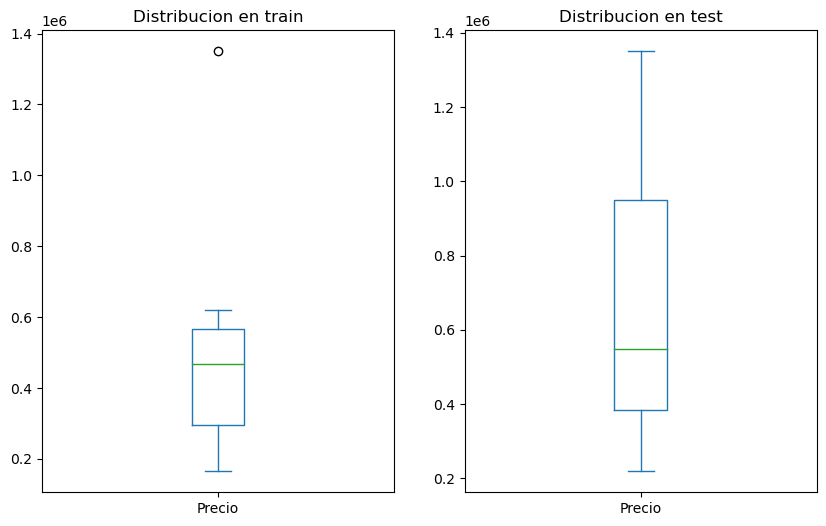

In [39]:
fig,axs = plt.subplots(1,2, figsize = (10,6))
datosTrainConResiduos[datosTrainConResiduos["distrito/ciudad"] =="chamberí"]["Precio"].plot(ax = axs[0],kind = "box")
datosTestConResiduos[datosTestConResiduos["distrito/ciudad"] =="chamberí"]["Precio"].plot(ax = axs[1],kind = "box")
axs[0].set_title("Distribucion en train")
axs[1].set_title("Distribucion en test")
axs[0].set_yticks([200000, 400000, 600000, 800000, 1000000, 1200000, 1400000])
plt.show()

Observamos que la distribución del precio de las casas es muy diferente en train y test. El modelo se está entrenando con datos que no representan adecuadamente la distribución de la población, es probable que el modelo esté sesgado y, como es el caso, que no generalice bien a nuevos datos.

Para intentar solucionar esto, vamos a intentar estratificar además de por el distrito, por el precio. Hacer una doble estratificación no es posible, sin embargo, podemos combinar los datos del precio con la localización. Calculamos la mediana de los precios de las viviendas por región y clasificamos las casas según si son más caras o baratas. Después, juntamos esta información con el distrito al que pertenece obteniendo un string como el siguiente: "caro_moncloa" o "barato_moncloa". De esta forma, estratificamos por regiones y precio. Habíamos pensado en dividir en más partes la columna precio (por cuartiles), pero obtenemos categorías con solo un valor y no podemos estratificarlo.

vamos a intentar estratificar los datos con la superificie de la csaa también

In [40]:
mediana_precio_localizacion = datos.groupby("distrito/ciudad")["Precio"].median()

def etiquetar_precio(row):
    if row["Precio"] > mediana_precio_localizacion[row["distrito/ciudad"]]:
        return "caro"
    else:
        return "barato"

estratificacion = datos.apply(etiquetar_precio, axis=1)

estratificacion_final = estratificacion + '_' + datos["distrito/ciudad"]


In [41]:
X = datos.drop(columns = "Precio")
y = datos["Precio"]
X_train, X_test, y_train, y_test = split_train_trest(X,y,estratificacion_final)
X_train_encoded, X_test_encoded= one_hot_encoder([X_train, X_test])
X_train_encoded_scaled,X_test_encoded_scaled = standardize(X_train_encoded, X_test_encoded)

__Volvemos a entrenar el mejor  modelo__

In [42]:
train_errors = []
test_errors = []
alphas = [0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,300]
for alpha in alphas :
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("ridge_reg", Ridge(alpha=alpha))
    ])

    # Entrenar el modelo
    pipeline.fit(X_train_encoded_scaled, y_train)

    # Calcular el error en el conjunto de entrenamiento
    train_error = calculate_error(pipeline, X_train_encoded_scaled, y_train)
    train_errors.append(train_error)

    # Calcular el error en el conjunto de prueba
    test_error = calculate_error(pipeline, X_test_encoded_scaled, y_test)
    test_errors.append(test_error)

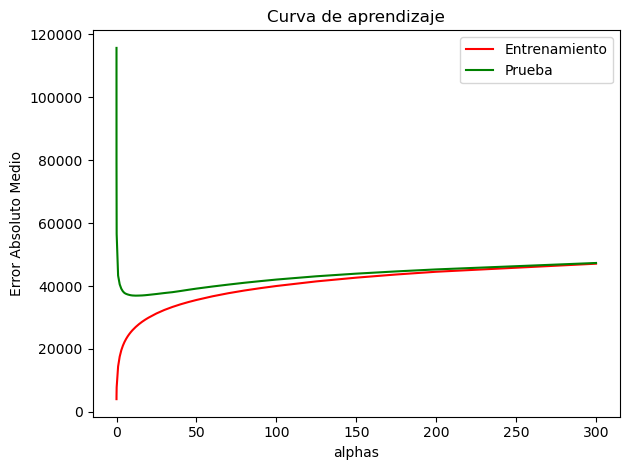

In [43]:
import matplotlib.pyplot as plt

# Dibujar líneas
plt.plot(alphas, train_errors, color="r",  label="Entrenamiento")
plt.plot(alphas, test_errors, color="g", label="Prueba")

# Crear el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("alphas"), plt.ylabel("Error Absoluto Medio"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


Observamos que a mayor alphas, menor diferencia entre el train y el test. Para elegir el mejor valor de alphas, intentamos elegir un valor que minimize la diferencia entre le train el test y el test_error. Considereamos que alpha = 30 es un buen valor

In [245]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),  # Puedes ajustar el grado del polinomio aquí
    ("ridge_reg", Ridge(alpha=30))  # Regularización Ridge, puedes ajustar el parámetro de regularización alpha
])

# Entrenar el modelo
pipeline.fit(X_train_encoded_scaled, y_train)

calculate_error(pipeline,X_test_encoded_scaled,y_test),calculate_error(pipeline,X_train_encoded_scaled,y_train)

(37779.75587121816, 32412.133782121306)

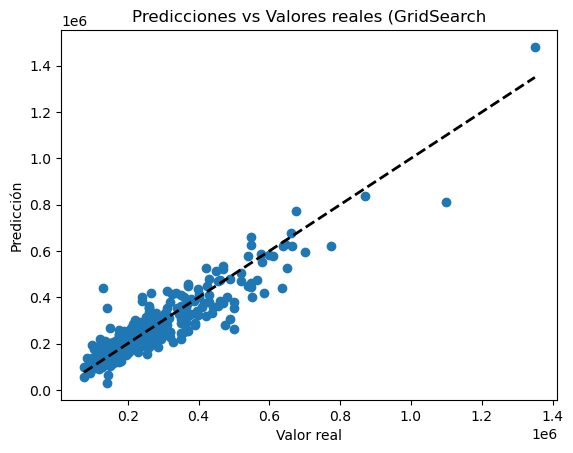

In [244]:
plt.scatter(y_test, pipeline.predict(X_test_encoded_scaled))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Línea diagonal
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales (GridSearch")
plt.show()

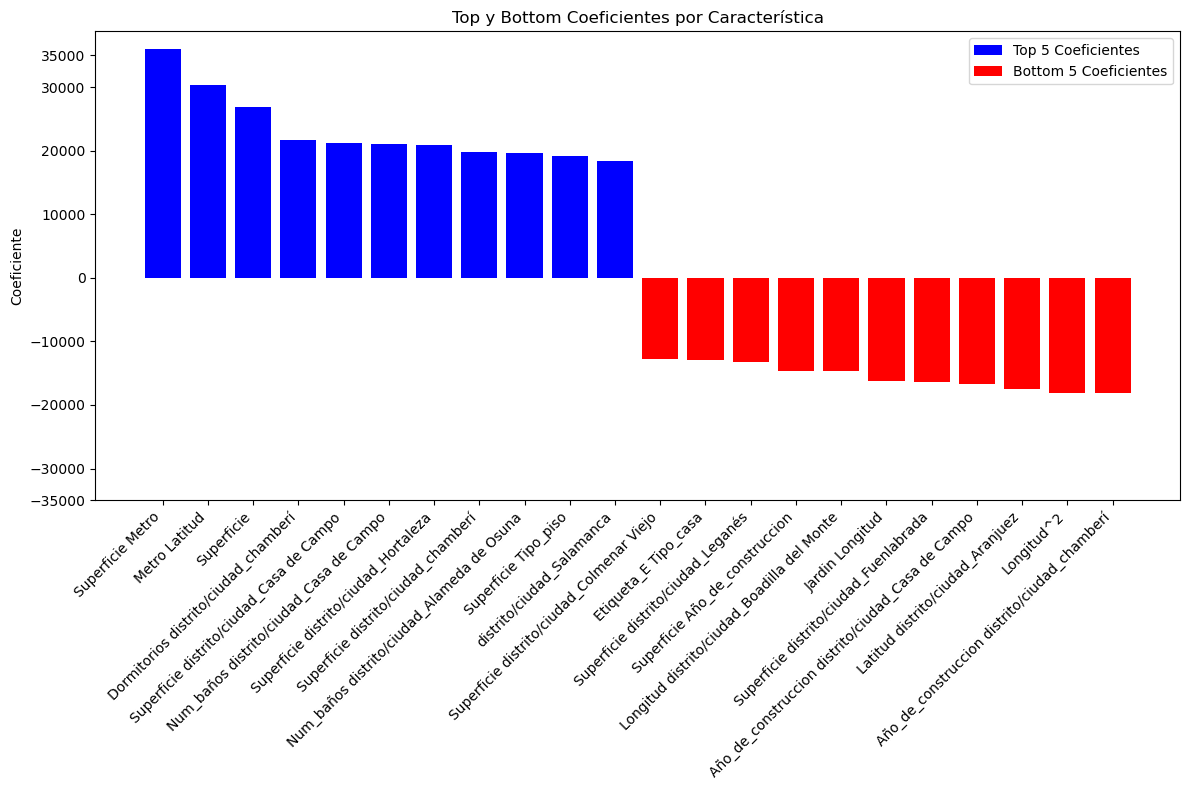

In [255]:
import matplotlib.pyplot as plt

coeficientes = pipeline.named_steps['ridge_reg'].coef_
columnas_coeficientes = pipeline.named_steps['poly_features'].get_feature_names_out(input_features=X_train_encoded.columns)

coeficientes_df = pd.DataFrame({'Coeficiente': coeficientes, 'Feature': columnas_coeficientes})

coeficientes_df_sorted = coeficientes_df.sort_values(by='Coeficiente',ascending = True)

mejores_coeficientes = coeficientes_df_sorted.tail(11)
peores_coeficientes = coeficientes_df_sorted.head(11)

mejores_coeficientes = mejores_coeficientes.sort_values(by = "Coeficiente",ascending =False)
peores_coeficientes = peores_coeficientes.sort_values(by = "Coeficiente",ascending =False)

plt.figure(figsize=(12, 8))

plt.bar(mejores_coeficientes['Feature'], mejores_coeficientes['Coeficiente'], color="blue", label="Top 5 Coeficientes")

plt.bar(peores_coeficientes['Feature'], peores_coeficientes['Coeficiente'], color="red", label="Bottom 5 Coeficientes")

plt.ylabel("Coeficiente")
plt.title("Top y Bottom Coeficientes por Característica")
plt.yticks([-35000,-30000,-20000,-10000,0,10000,20000,30000,35000])
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para
plt.legend()
plt.tight_layout()
plt.show()



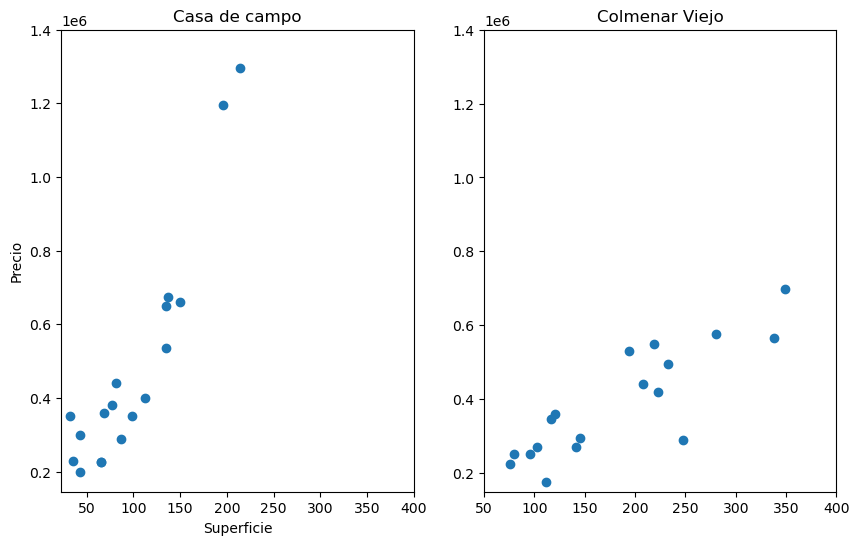

In [239]:
fig,axs = plt.subplots(1,2, figsize = (10,6))
axs[0].scatter(datos[datos["distrito/ciudad"] == "Casa de Campo"]["Superficie"],datos[datos["distrito/ciudad"] == "Casa de Campo"]["Precio"])
axs[1].scatter(datos[datos["distrito/ciudad"] == "Colmenar Viejo"]["Superficie"],datos[datos["distrito/ciudad"] == "Colmenar Viejo"]["Precio"])
axs[0].set_yticks([200000,400000,600000,800000,1000000,1200000,1400000])
axs[1].set_yticks([200000,400000,600000,800000,1000000,1200000,1400000])
axs[0].set_xticks([50,100,150,200,250,300,350,400])
axs[1].set_xticks([50,100,150,200,250,300,350,400])
axs[0].set_title("Casa de campo")
axs[0].set_xlabel("Superficie")
axs[0].set_ylabel("Precio")
axs[1].set_title("Colmenar Viejo")
plt.show()

Observamos que el modelo polinómico captura relaciones más complejas que el resto de modelos. Analizando la grafica de los coeficientes relevantes podemos destacar un caso muy interesante, el modelo polinomico ha creado variables como "Superficie Casa de Campo" y "Superficie Colmenar Viejo". El coeficiente de la primera tiene un coeficiente positivo grande(17000) por el contrario, el segundo tiene un coeficiente grande negativo (más de 10000).Viendo los scatters que muestran la relación entre la superficie y el precio de ambas localidades, vemos que tiene mucho sentido lo que hace, ya que en la primera las casas tienen un precio de m2 muy alto por lo que tiene sentido crear una variable para potencia el precio de la superificie para esa región en especifico.Para el caso de "Colmenar Viejo" pasa totalmente lo contrario por lo que nuestro modelo crea una variable con coeficiente negativo para ajustar lo mejor posible el precio.

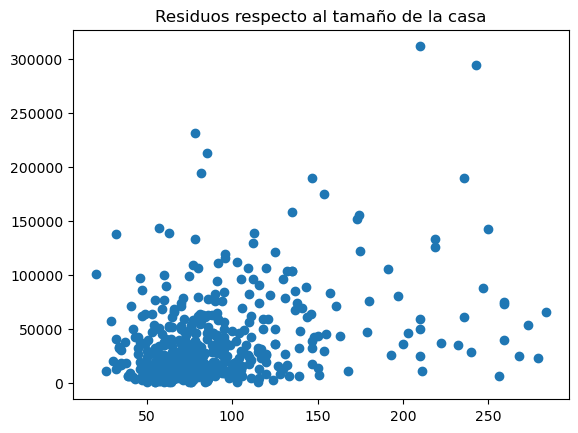

In [106]:
predicciones = pipeline.predict(X_test_encoded_scaled)
residuos = abs(predicciones-y_test)
plt.scatter(X_test_encoded["Superficie"],residuos)
plt.title("Residuos respecto al tamaño de la casa")
plt.show()

Volvemos a concatenar los datos con el residuos que han generado 

In [218]:
datosTestConResiduos,datosTrainConResiduos = concat_input_output(residuos,X_test,y_test,X_train,y_train)


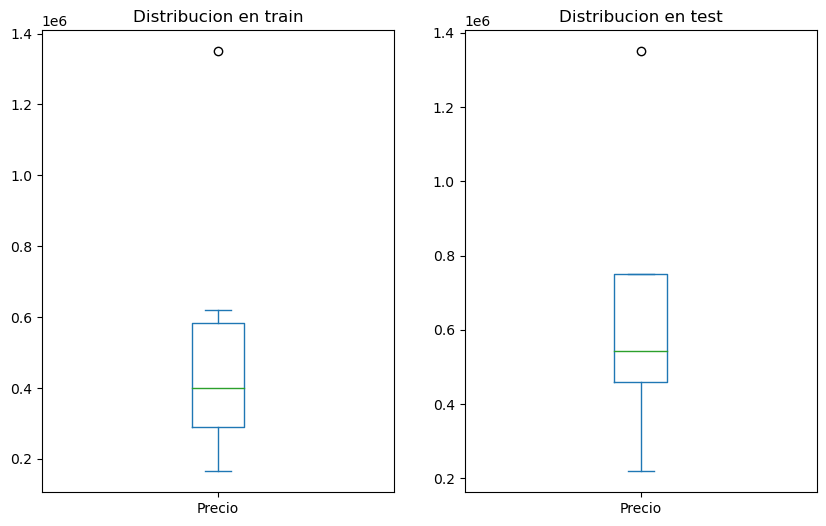

In [219]:
fig,axs = plt.subplots(1,2, figsize = (10,6))
datosTrainConResiduos[datosTrainConResiduos["distrito/ciudad"] =="chamberí"]["Precio"].plot(ax = axs[0],kind = "box")
datosTestConResiduos[datosTestConResiduos["distrito/ciudad"] =="chamberí"]["Precio"].plot(ax = axs[1],kind = "box")
axs[0].set_title("Distribucion en train")
axs[1].set_title("Distribucion en test")
axs[0].set_yticks([200000, 400000, 600000, 800000, 1000000, 1200000, 1400000])
plt.show()

__Analizamos un caso donde se equivoca mucho__

In [220]:
residuos[residuos > 300000]

164    311399.48379
Name: residuos, dtype: float64

In [221]:
residuos[residuos > 300000]
datos.loc[2617]

Precio                     128700.0
Dormitorios                     7.0
Superficie                    243.0
Num_baños                       2.0
Metro                           0.0
Renfe                           1.0
Tipo_de_inmueble            Popular
Año_de_construccion          1965.0
Calefaccion                     0.0
Etiqueta                 En proceso
Aire acondicionado              0.0
Ascensor                        0.0
Jardin                          0.0
Tipo                           casa
distrito/ciudad        Ciempozuelos
Latitud                   40.158009
Longitud                  -3.620551
Name: 2617, dtype: object

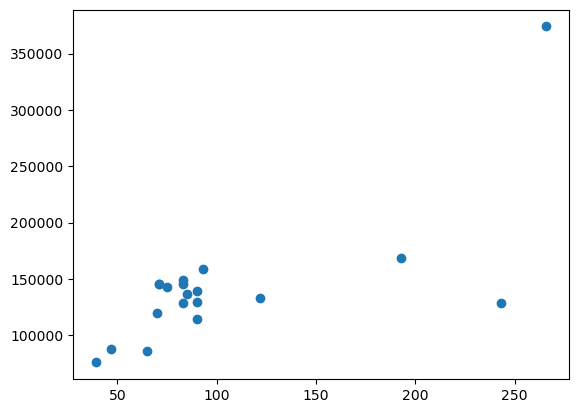

In [222]:
plt.scatter(datos[datos["distrito/ciudad"] == "Ciempozuelos"]["Superficie"],datos[datos["distrito/ciudad"] == "Ciempozuelos"]["Precio"])

Al examinar el gráfico de dispersión de residuos, identificamos una casa con un residuo extremadamente alto de 312685. Para estudiar mas a fondo este caso realizamos un scatter de superficie/precio.Observamos que está casa es mucho más barata de lo que debería, ya que cuesta similar a casas con mitad de tamaño.Por otra parte, observamos que una vivenda casi igual a la nuestra cuesta mas de 350000,más del doble que esta.

In [223]:
distritos_con_residuos_altos,distritos_con_residuos_bajos =  obtener_distritos_con_gran_error(y_test,residuos,X_test)

In [224]:
distritos_con_residuos_altos.sort_values(by = "Residuos",ascending = False)

,Residuos
Distrito/Ciudad,
Tres Cantos,138585.687162
Concepción,120064.540359
Chamartín,110056.756055
pacífico,104890.233774
Alameda de Osuna,103635.257320
Cortes,87507.364178
Torrelodones,85862.628895
Camarma de Esteruelas,83689.379255
Brunete,81916.782084


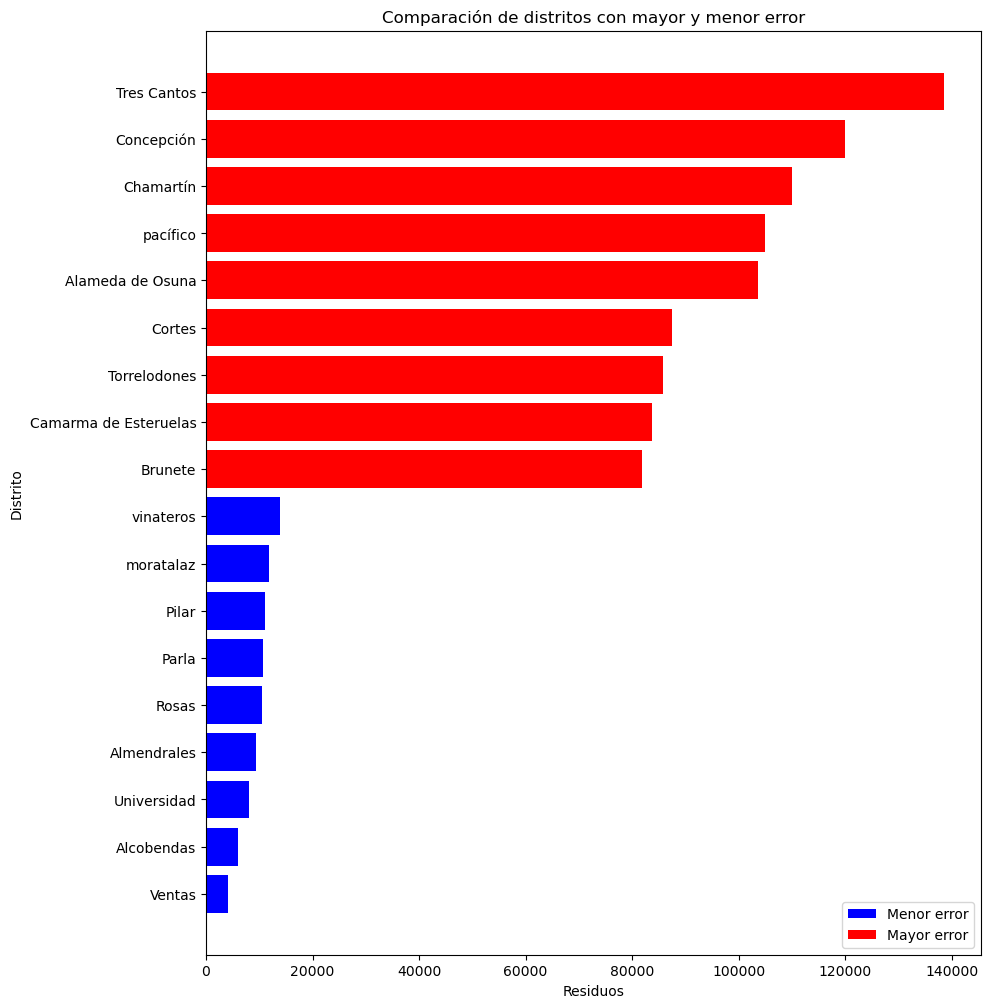

In [254]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

distritos_con_residuos_altos = distritos_con_residuos_altos.sort_values(by="Residuos")
distritos_con_residuos_bajos = distritos_con_residuos_bajos.sort_values(by="Residuos")

ax.barh(distritos_con_residuos_bajos.index, distritos_con_residuos_bajos["Residuos"], color='blue', label='Menor error')


ax.barh(distritos_con_residuos_altos.index, distritos_con_residuos_altos["Residuos"], color='red', label='Mayor error')


ax.set_title("Comparación de distritos con mayor y menor error")
ax.set_xlabel("Residuos")
ax.set_ylabel("Distrito")

ax.legend()

plt.savefig("ComparacionErrores.png")

plt.show()


In [117]:
casas = datos[datos["distrito/ciudad"].isin(distritos_con_residuos_altos.index)]["distrito/ciudad"].value_counts()
distritos_residuos_altos = distritos_con_residuos_altos.index.values
casas_residuos_altos = [casas[distritos_residuos_altos.tolist().index(d)] for d in distritos_residuos_altos]


In [118]:
casas = datos[datos["distrito/ciudad"].isin(distritos_con_residuos_bajos.index)]["distrito/ciudad"].value_counts()
distritos_residuos_bajos = distritos_con_residuos_bajos.index.values
casas_residuos_bajos = [casas[distritos_residuos_bajos.tolist().index(d)] for d in distritos_residuos_bajos]


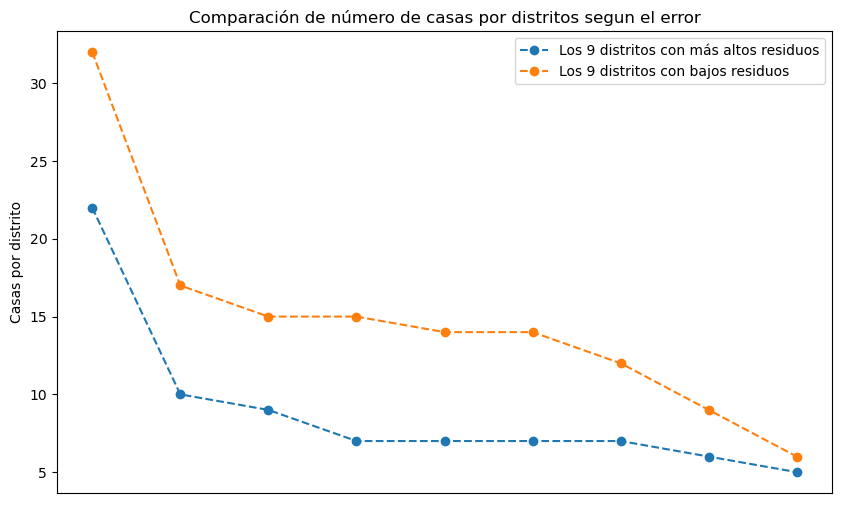

<Figure size 640x480 with 0 Axes>

In [235]:
fig,ax = plt.subplots(figsize=(10,6))
x = np.arange(0,9)
ax.plot(x,casas_residuos_altos,marker='o', linestyle='--',label = "Los 9 distritos con más altos residuos")
ax.plot(x,casas_residuos_bajos,marker='o', linestyle='--',label = "Los 9 distritos con bajos residuos")
ax.set_title("Comparación de número de casas por distritos segun el error")
ax.set_ylabel("Casas por distrito")
ax.legend()
ax.set_xticks([])
plt.show()
plt.savefig("ComparaciónCasasError2.png")

Observamos una desigualdad significativa entre los distritos con bajos y altos niveles de residuos: mientras que los primeros tienen un número considerablemente mayor de viviendas por distrito, los segundos muestran una menor densidad de viviendas.La falta de información en ciertos distritos no permite generalizar y produce  un sobreajuste a los datos disponibles en esos distritos específicos.

## RFE

Para el RFE, hemos introducido una pequeña modficación a la implementación. Al tener muchas columnas que han sido tranformadas por one-hot-encoding y que en realidad eran una unica columna, por ejemplo la columna etiqueta que se ha convertido en las siguientes columnas(['En proceso', 'E', 'G', 'D', 'F', 'C', 'A+', 'B'],pensamos que no tiene mucho sentido eleminar por ejemplo la etiqueta ["A+","E","D] y dejar el resto.Por lo que hemos modificado el código para tener una lista de "related_features", con ello si eleminamos una, se elimina el resto. Tambien hemos protegido las columnas de la localización porque son importante para nuestro modelo. Vamos a probar los dos modelos, el customizado y el que no.

Custom

In [256]:
modelo_polinomico_ridge_rfe_grid,resultados,columnas_seleccionadas = polinomical_regression_model_rfe(X_train_encoded_scaled,y_train,custom = True)
resultados["test_error"] = calculate_error(modelo_polinomico_ridge_rfe_grid,X_test_encoded_scaled[columnas_seleccionadas],y_test)
resultados["RFE_Custom"] = True 
save_results_mlflow(resultados,"modelo_polinomico_ridge_rfe_grid",modelo_polinomico_ridge_rfe_grid)
resultados,columnas_seleccionadas


linear_regression_model_grid_cv_rfe


({'Modelo': 'linear_regression_model_grid_cv_rfe',
  'stratify': True,
  'rfe': True,
  'cv': True,
  'mean_validation_error': 50593.41891169268,
  'best_params': {'alpha': 1, 'tol': 0.01},
  'cross_validation': [{'alpha': '',
    'tol': '',
    'validation_error': 50593.41891169268},
   {'alpha': 1, 'tol': 0.01, 'validation_error': 50593.41891169268},
   {'alpha': 1, 'tol': 0.001, 'validation_error': 50593.41891169268},
   {'alpha': 1, 'tol': 0.0001, 'validation_error': 50620.42210565922},
   {'alpha': 2, 'tol': 0.01, 'validation_error': 50620.42210565922},
   {'alpha': 2, 'tol': 0.001, 'validation_error': 50620.42210565922},
   {'alpha': 2, 'tol': 0.0001, 'validation_error': 51116.26841676777},
   {'alpha': 3, 'tol': 0.01, 'validation_error': 51116.26841676777},
   {'alpha': 3, 'tol': 0.001, 'validation_error': 51116.26841676777},
   {'alpha': 3, 'tol': 0.0001, 'validation_error': 51825.86152081932},
   {'alpha': 4, 'tol': 0.01, 'validation_error': 51825.86152081932},
   {'alpha': 4,

Sin customizar

In [257]:
modelo_polinomico_ridge_rfe_grid_no_custom,resultados,columnas_seleccionadas = polinomical_regression_model_rfe(X_train_encoded_scaled,y_train,custom = False)
save_results_mlflow(resultados,"modelo_polinomico_ridge_rfe_grid_sin_custom",modelo_polinomico_ridge_rfe_grid)
resultados["test_error"] = calculate_error(modelo_polinomico_ridge_rfe_grid_no_custom,X_test_encoded_scaled[columnas_seleccionadas],y_test)
resultados["RFE_Custom"] = False 
resultados,columnas_seleccionadas

linear_regression_model_grid_cv_rfe


({'Modelo': 'linear_regression_model_grid_cv_rfe',
  'stratify': True,
  'rfe': True,
  'cv': True,
  'mean_validation_error': 50570.71105335749,
  'best_params': {'alpha': 1, 'tol': 0.01},
  'cross_validation': [{'alpha': '',
    'tol': '',
    'validation_error': 50570.71105335749},
   {'alpha': 1, 'tol': 0.01, 'validation_error': 50570.71105335749},
   {'alpha': 1, 'tol': 0.001, 'validation_error': 50570.71105335749},
   {'alpha': 1, 'tol': 0.0001, 'validation_error': 50870.02188675602},
   {'alpha': 2, 'tol': 0.01, 'validation_error': 50870.02188675602},
   {'alpha': 2, 'tol': 0.001, 'validation_error': 50870.02188675602},
   {'alpha': 2, 'tol': 0.0001, 'validation_error': 51577.83706910978},
   {'alpha': 3, 'tol': 0.01, 'validation_error': 51577.83706910978},
   {'alpha': 3, 'tol': 0.001, 'validation_error': 51577.83706910978},
   {'alpha': 3, 'tol': 0.0001, 'validation_error': 52284.818344437415},
   {'alpha': 4, 'tol': 0.01, 'validation_error': 52284.818344437415},
   {'alpha': 

El modelo customizado funciona mejor pero seguimos sin mejorar el modelo ridge normal